# Reinforcement Learning Basics with CartPole Model

## Problem Definition

CartPole model is a simple example of control problem in a simplified physical environment. The goal is to balance a pole with a mass $m$ and length $l$ on a moving cart by applying discrete forces to the cart in gorisontal direction. The environment is characterized by cart position $x$, cart velocity $x'$, pole angle $\theta$, and pole angular velocity $\theta'$. The action space $A$ include discrete horisontal forces applied to the cart in negative ($a=0$) or positive ($a=1$) direction.

<!-- ```{figure} 1_RL_basics_Fig1_CartPole.png
---
width: 300px
name: basic-cartpole
---
Basic CartPole model
```-->

```{image} 1_RL_basics_Fig1_CartPole.png
:width: 300px
:name: basic-cartpole
```

<!-- ![Figure 1](1_RL_basics_Fig1_CartPole.png) -->
<!-- <img src="1_RL_basics_Fig1_CartPole.png" width="300px"/> -->

The model is implemented in Gymnasium library {cite}`CartPole` with basics physics enabling simulation of various control mechanisms. Here the observation space is defined by a vector $(x,x',\theta,\theta')$, action space is $A=\{0,1\}$. The agent receives +1 for every timestep the pole remains upright. The episode ends if: a) the pole tilts more than 15 degrees from vertical; b) the cart moves more than 2.4 units from the center; c) the episode length exceeds 500 steps.

Within this practical task we'll implement and evaluate a basic RL agent to control the cart in an optimal way using Gymnasium environment with REINFORCE algorithm {cite}`Williams1992`.

<!-- ### References
1. [Cart Pole in Gymnasium Documentation](https://gymnasium.farama.org/environments/classic_control/cart_pole/)
2. [R. J. Williams, Simple statistical gradient-following algorithms for connectionist reinforcement learning, Machine Learning, vol. 8, no. 23, 1992.](https://link.springer.com/content/pdf/10.1007/BF00992696.pdf) -->


## Implementation

### Basic initialization

First, we import necessary libraries neededd for our experimental setting and create an instance of CartPole environment from Gymnasium. We see the action space is discrete with two option (positive and negative forces). The opservation space is continuous 4-dimension space.

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import gymnasium as gym
from tqdm.notebook import tqdm

In [3]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.action_space, env.observation_space

(Discrete(2),
 Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32))

### Simple run

To run a basic experiment with CartPole we apply sequential steps with randome action selected with `sample()` method of action space in the environment.

In [4]:
env.reset()

term = False
trunc = False
total_reward = 0
while not (term or trunc):
   env.render()
   obs, rew, term, trunc, info = env.step(env.action_space.sample())
   total_reward += rew
   print(f"{obs} -> {rew}")
print(f"Total reward: {total_reward}")

env.close()

[-0.02803049  0.21940807 -0.01105825 -0.29289705] -> 1.0
[-0.02364233  0.02444551 -0.01691619 -0.00372216] -> 1.0
[-0.02315342  0.21980593 -0.01699063 -0.30169398] -> 1.0
[-0.0187573   0.41516587 -0.02302451 -0.5996866 ] -> 1.0
[-0.01045398  0.22037348 -0.03501824 -0.31434408] -> 1.0
[-0.00604651  0.02576741 -0.04130512 -0.0329072 ] -> 1.0
[-0.00553116 -0.16873862 -0.04196327  0.24646273] -> 1.0
[-0.00890593  0.02695676 -0.03703402 -0.05915549] -> 1.0
[-0.0083668  -0.16761516 -0.03821712  0.22161676] -> 1.0
[-0.0117191  -0.3621706  -0.03378479  0.5020037 ] -> 1.0
[-0.01896252 -0.16658913 -0.02374471  0.1988681 ] -> 1.0
[-0.0222943   0.02886425 -0.01976735 -0.10120961] -> 1.0
[-0.02171701 -0.16596891 -0.02179154  0.18517181] -> 1.0
[-0.02503639  0.02945794 -0.01808811 -0.11430509] -> 1.0
[-0.02444723  0.22483434 -0.02037421 -0.41263935] -> 1.0
[-0.01995054  0.4202391  -0.028627   -0.7116752 ] -> 1.0
[-0.01154576  0.6157455  -0.0428605  -1.0132298 ] -> 1.0
[ 7.6914678e-04  8.1141216e-01 

## Experiments

### Basic Q-learning

We implement a basic learning procedure with a neural network with one fullly connected layer (128 neurons) with observation space as an input and action space as an output.

In [6]:
num_inputs = 4
num_actions = 2

model = keras.Sequential([
    keras.Input(shape=(num_inputs,)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(num_actions, activation="softmax")
])

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.01))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               640       
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 898
Trainable params: 898
Non-trainable params: 0
_________________________________________________________________


Next, we need implementation of episode simulation with sequential application of the model. We define a function that run an episode and collect a trace as a history of states, actions, probabilities returned by a model, and obtained rewards.

Additionally, we define a discounted reward function which weight a reward vector within a trace so that earlier rewards will be discounted by a coefficient `gamma`.

In [7]:
def run_episode(max_steps_per_episode = 1000):
    states, actions, probs, rewards = [],[],[],[]
    state = env.reset()[0]
    for _ in range(max_steps_per_episode):
        action_probs = model(np.expand_dims(state, 0))[0]
        action = np.random.choice(num_actions, p=np.squeeze(action_probs))
        nstate, reward, term, trunc, info = env.step(action)
        if term or trunc:
            break
        states.append(state)
        actions.append(action)
        probs.append(action_probs)
        rewards.append(reward)
        state = nstate
    return np.vstack(states), np.vstack(actions), np.vstack(probs), np.vstack(rewards)

eps = 0.0001

def discounted_rewards(rewards, gamma=0.99, normalize=True):
    ret = []
    s = 0
    for r in rewards[::-1]:
        s = r + gamma * s
        ret.insert(0, s)
    if normalize:
        ret = (ret-np.mean(ret))/(np.std(ret)+eps)
    return ret

In [8]:
s,a,p,r = run_episode()
print(f"Total reward: {np.sum(r)}")
print(f"Total discounted reward: {np.sum(discounted_rewards(r))}")

Total reward: 11.0
Total discounted reward: -6.661338147750939e-16


### Simple policy gradient learning

Here we implement a basic policy gradient method with REINFORCE algorithm. We run the CartPole model episode `n_episodes` times (epochs) and collect trace information. After each run, the following steps are repeated:
1. Selected actions are converted into one-hot encoding `one_hot_actions`. E.g. vector of actions `[0,1,0]` will be converted into `[[1,0], [0,1], [1,0]`.
2. We calculate the policy `gradients` as difference between action probabilities and encoded actions being taken. This gives the direction to adjust the policy to increase the likelihood of good actions.
3. Discounted rewards `dr` are calculated with the function defined above.
4. We multiplies `gradients` by discounted rewards `dr` to reinforce actions that led to higher rewards. Actions with higher rewards get larger updates.
5. To calculate `target` we scales the gradient by the learning rate `alpha` and add action probabilities `probs` to ensure the update is incremental (avoids drastic policy changes).
6. The `target` is used to train the model in association with `states` using `train_on_batch()` method.

We collect training history with obtained reward. Also, the reward is shown once per each 100 epochs.

In [9]:
alpha = 5e-4
n_episodes = 300

history = []
for epoch in tqdm(range(n_episodes)):
    states, actions, probs, rewards = run_episode()
    one_hot_actions = np.eye(2)[actions.T][0]
    gradients = one_hot_actions-probs
    dr = discounted_rewards(rewards)
    gradients *= dr
    target = alpha*np.vstack([gradients])+probs
    model.train_on_batch(states,target)
    history.append(np.sum(rewards))
    if epoch%50==0:
        print(f'E: {epoch:3} R: {np.sum(rewards)}')

  0%|          | 0/300 [00:00<?, ?it/s]

E:   0 R: 24.0
E:  50 R: 95.0
E: 100 R: 132.0
E: 150 R: 159.0
E: 200 R: 499.0
E: 250 R: 499.0


Text(0, 0.5, 'Accumulated reward')

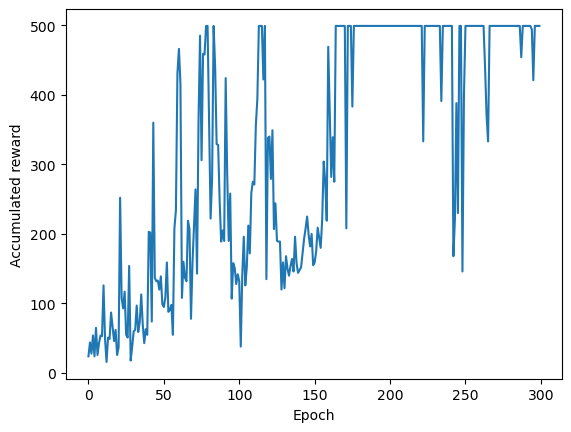

In [10]:
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Accumulated reward')

### Adding observation noise

For experimental analysis of learning process with noise environment, we can modify `run_episode` with additive noise component to see how it will affect RL performance.

In [11]:
model_with_noise = keras.Sequential([
    keras.Input(shape=(num_inputs,)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(num_actions, activation="softmax")
])

model_with_noise.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.01))

model_with_noise.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               640       
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                                 
Total params: 898
Trainable params: 898
Non-trainable params: 0
_________________________________________________________________


In [12]:
NOISE_STD = 1e-1

def run_episode_with_noise(max_steps_per_episode = 10000):
    states, actions, probs, rewards = [],[],[],[]
    state = env.reset()[0]
    for _ in range(max_steps_per_episode):
        noise_component = np.random.normal(0, NOISE_STD, len(state)) # DEFINING NOIZE COMPONENT
        state_observed = state + noise_component # ADDING NOIZE COMPONENT
        action_probs = model_with_noise(np.expand_dims(state_observed, 0))[0]
        action = np.random.choice(num_actions, p=np.squeeze(action_probs))
        nstate, reward, term, trunc, info = env.step(action)
        if term or trunc:
            break
        states.append(state_observed)
        actions.append(action)
        probs.append(action_probs)
        rewards.append(reward)
        state = nstate
    return np.vstack(states), np.vstack(actions), np.vstack(probs), np.vstack(rewards)

In [13]:
history_with_noise = []
for epoch in tqdm(range(n_episodes)):
    states, actions, probs, rewards = run_episode_with_noise()
    one_hot_actions = np.eye(2)[actions.T][0]
    gradients = one_hot_actions-probs
    dr = discounted_rewards(rewards)
    gradients *= dr
    target = alpha*np.vstack([gradients])+probs
    model_with_noise.train_on_batch(states,target)
    history_with_noise.append(np.sum(rewards))
    if epoch%50==0:
        print(f'E: {epoch:3} R: {np.sum(rewards)}')

  0%|          | 0/300 [00:00<?, ?it/s]

E:   0 R: 8.0
E:  50 R: 170.0
E: 100 R: 499.0
E: 150 R: 168.0
E: 200 R: 142.0
E: 250 R: 499.0


Text(0, 0.5, 'Accumulated reward')

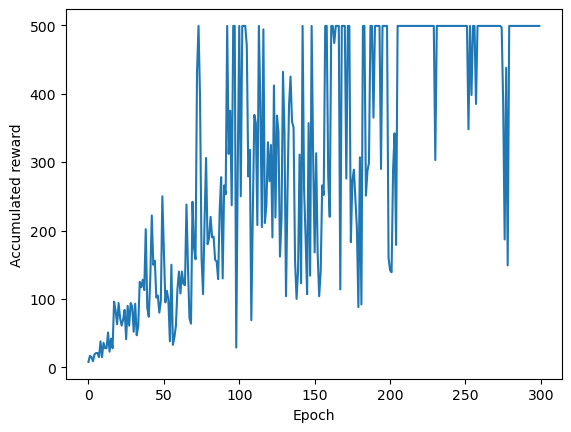

In [14]:
plt.plot(history_with_noise)
plt.xlabel('Epoch')
plt.ylabel('Accumulated reward')

## Conclusion

It can be observed that the basic implementation of the algorithm shows relatively "unstable" behavior deviating from reaching maximal reward (here, 500). The behavior become worthier when adding noise component to state observation. However, policy close to optimal is reachable even in the observed limited conditions.